# Notebook to analyse the apparent magnitudes of this AGN

Import the necessary packages

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from alerce.core import Alerce
client = Alerce()
stamps = client.get_stamps("ZTF18absrlhv")

Query the data using alerce and extract the columns

In [15]:
# Getting lightcurve for an object
lc = client.query_lightcurve("ZTF18absrlhv",
                                     format="json")

In [16]:
detections = pd.DataFrame(lc["detections"])
nondetections = pd.DataFrame(lc["non_detections"])

print(np.shape(detections))
print(np.shape(nondetections))

print(detections.columns)
print(nondetections.columns)

(2431, 34)
(683, 4)
Index(['tid', 'mjd', 'candid', 'fid', 'pid', 'diffmaglim', 'isdiffpos', 'nid',
       'distnr', 'magpsf', 'magpsf_corr', 'magpsf_corr_ext', 'magap',
       'magap_corr', 'sigmapsf', 'sigmapsf_corr', 'sigmapsf_corr_ext',
       'sigmagap', 'sigmagap_corr', 'ra', 'dec', 'rb', 'rbversion', 'drb',
       'magapbig', 'sigmagapbig', 'rfid', 'has_stamp', 'corrected', 'dubious',
       'candid_alert', 'step_id_corr', 'phase', 'parent_candid'],
      dtype='object')
Index(['tid', 'mjd', 'fid', 'diffmaglim'], dtype='object')


Filter the data to obtain reliable measurements only

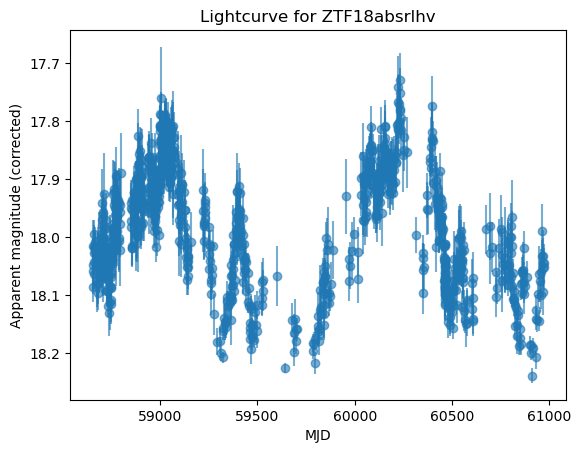

In [49]:
good = detections[
    (detections["dubious"] == False)
    & (detections["drb"] > 0.5)
    & (detections["sigmapsf_corr"] < 1e2)  # remove those 100.0 placeholder errors
    & (detections["fid"] == 1) # select only g-band
]

plt.errorbar(good["mjd"], good["magpsf_corr"], yerr=good["sigmapsf_corr"], 
             fmt="o", alpha=0.6)
plt.gca().invert_yaxis()
plt.xlabel("MJD")
plt.ylabel("Apparent magnitude (corrected)")
plt.title("Lightcurve for ZTF18absrlhv")
plt.show()

Split the observation into two halfs!

In [ ]:
good = good.sort_values(by="mjd")
duration = len(good)
print("Total data points:", duration)

mid_point = duration // 2

first_half = good.iloc[:mid_point]
second_half = good.iloc[mid_point:]


print(len(first_half), len(second_half))

Total data points: 983
491 492


Better: Split the data by observing time!

In [35]:
mid_point = (good['mjd'].min() + good['mjd'].max()) / 2

first_half = good[good['mjd'] <= mid_point]
second_half = good[good['mjd'] > mid_point]

print(len(first_half), len(second_half))

574 409


Define functions for weighted mean and the corresponding standard deviations

In [ ]:
def weighted_mean(mags, errs):
    assert len(mags) != len(errs), print("⚠️ Measurements and errors need to have the same dimensions!")
    N = len(mags)
    mean = np.sum(mags*errs) / np.sum(errs)
    return mean

Calculate constant fit to the data in each half!

In [ ]:


mean1, mean2 = np.mean(first_half["magpsf_corr"]), np.mean(second_half["magpsf_corr"])



median1, median2 = np.median(first_half["magpsf_corr"]), np.median(second_half["magpsf_corr"])



std1, std2 = np.std(first_half["magpsf_corr"]), np.std(second_half["magpsf_corr"])

print(f"First half mean = {mean1:.3f} ± {std1:.3f}")
print(f"Second half mean = {mean2:.3f} ± {std2:.3f}")

print(f"First half median = {median1:.3f}")
print(f"Second half median = {median2:.3f}")

First half mean = 17.972 ± 0.096
Second half mean = 18.000 ± 0.105
First half median = 17.965
Second half median = 18.023


Plot again with its mean

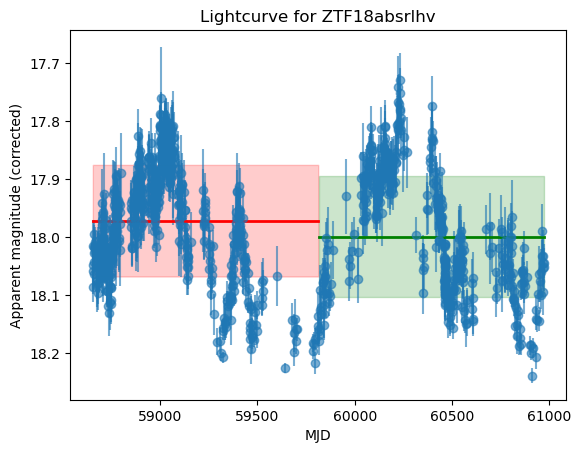

In [43]:
plt.errorbar(good["mjd"], good["magpsf_corr"], yerr=good["sigmapsf_corr"], 
             fmt="o", alpha=0.6)

plt.plot(first_half["mjd"], [mean1]*len(first_half), color="red", label="First half mean", lw=2)
plt.fill_between(first_half["mjd"], [mean1+std1]*len(first_half), [mean1-std1]*len(first_half), color="red", alpha=0.2)

plt.plot(second_half["mjd"], [mean2]*len(second_half), color="green", label="Second half mean", lw=2)
plt.fill_between(second_half["mjd"], [mean2+std2]*len(second_half), [mean2-std2]*len(second_half), color="green", alpha=0.2)
plt.gca().invert_yaxis()
plt.xlabel("MJD")
plt.ylabel("Apparent magnitude (corrected)")
plt.title("Lightcurve for ZTF18absrlhv")
plt.show()

Statistical analysis

In [47]:
diff = np.abs(mean1 - mean2)
total_err = np.sqrt(std1**2 + std2**2)

Nsig = diff/total_err

print("Difference in apparent magnitudes: ", diff)
print("Total uncertainty: ", total_err)


print(f"The difference in apparent magnitude is {Nsig * 100:.2f}% of the errors")

Difference in apparent magnitudes:  0.02755472001908288
Total uncertainty:  0.14235961006056977
The difference in apparent magnitude is 19.36% of the errors
